# 気象台東交差点の所要時間予測

<div style="text-align: right;">
    <a href="kishodaiAnalysis.ipynb">このページのオリジナルのipynbファイル</a>
    更新日  2021-01-09 10:44:26 
</div>

機械学習による所要時間予測の試み

## データの読み込みと集計

クラスファイルを作成

- 各ルートについて
 - 前の時刻との差(diff)を取る関数
 - 移動平均を取る関数 (併せて、前の時間帯の移動平均を取っておく：１つ（5分）前～４つ(20分)前

- ３つのルートをマージする関数

In [21]:
# 8tops上で採取しているデータの閲覧
from datetime import datetime as dt, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter  # 時間軸のフォーマットを自在に

plt.rcParams["font.size"] = 14

class kishodaiAnalysis:
    def __init__(self):
        self.df = {}
        dir = "/ssd/toyoki/googleData/kishodai/"
        
        # 気象台西　－　県立大入口　（飯田通）
        self.read_google_data("飯田", dir + "気象台西_県立大入口_travelTime.csv")        
        # 甲府工業西　－　西中北西　（アルプス通）
        self.read_google_data("アルプス", dir + "甲府工業西_西中北西_travelTime.csv")
        # 中央病院入口　－　県立大入口 （北西から東）
        self.read_google_data('富士見', dir + "中央病院入口_県立大入口_travelTime.csv")
        # 東向き３路線全体のデータフレームをつくる
        # self.makeIntegratedDataFrame()
        
    def read_google_data(self, id, csv_file):
        self.df[id] = pd.read_csv(csv_file, sep=",", skipinitialspace=True)         
        self.df[id]['date'] = pd.to_datetime(self.df[id]['date'],
                                                format='%Y/%m/%d %H:%M:%S').dt.round("T")
        
        # 統合のためにコラム名を変更
        self.df[id].rename(columns={'distance': id+'_distance',
                                    'fwd_std': id+'_fwd_std',
                                    'fwd': id+'_fwd',
                                    'rev': id+ '_rev',
                                    'rev_std': id+ '_rev_std'},
                           inplace=True)
        self.df[id]['dayofweek'] = self.df[id]['date'].dt.dayofweek # 曜日の列を追加
        
    ''' 前の時刻のデータを列として加える  '''
    def add_diffs(self, num):
        for id in self.df:
            #print(id)
            # 前の時刻との時間差を付け加える
            for i in range(1, num+1):
                self.df[id][id + '_diff_fwd' + str(i)] = self.df[id][id+'_fwd'].diff(i)       
                self.df[id][id + '_diff_rev' + str(i)] = self.df[id][id+'_rev'].diff(i)
                
    ''' 移動平均を付け加える '''
    def add_moving_averages(self, num):
        for id in self.df:
            # 移動平均　rollingしてmean ⇒ その時刻を含む過去num個の平均
            self.df[id][id + '_mvs_fwd'] = (self.df[id][id+'_fwd']
                                            .rolling(window=num).mean())
            self.df[id][id + '_mvs_rev'] = (self.df[id][id+'_rev']
                                            .rolling(window=num).mean())
            # 当該時刻よりも以前の移動平均を列に加える
            self.df[id][id + 'prev_mvs_fwd1'] = self.df[id][id+ '_mvs_fwd'].shift(1)
            self.df[id][id + 'prev_mvs_rev1'] = self.df[id][id+ '_mvs_rev'].shift(1) 
            self.df[id][id + 'prev_mvs_fwd2'] = self.df[id][id+ '_mvs_fwd'].shift(2)
            self.df[id][id + 'prev_mvs_rev2'] = self.df[id][id+ '_mvs_rev'].shift(2) 
            self.df[id][id + 'prev_mvs_fwd3'] = self.df[id][id+ '_mvs_fwd'].shift(3)
            self.df[id][id + 'prev_mvs_rev3'] = self.df[id][id+ '_mvs_rev'].shift(3) 
            self.df[id][id + 'prev_mvs_fwd4'] = self.df[id][id+ '_mvs_fwd'].shift(4)
            self.df[id][id + 'prev_mvs_rev4'] = self.df[id][id+ '_mvs_rev'].shift(4) 
            
    '''
    3路線を統合したデータフレームを作る（とりあえず、東、南向きのみ）df_all
    '''
    def makeIntegratedDataFrame(self):
        self.all_df = pd.merge(self.df['富士見'], self.df['飯田'], on='date')
        self.all_df = pd.merge(self.all_df, self.df['アルプス'], on='date')
        self.all_df['hourmin'] = self.all_df['date'].dt.strftime('%H:%M')


移動平均

window =3 の場合の8:00の行を例に
- mvs_fwd:        7:50, 7:55, 8:00の平均
- prev_mvs_fwd1:  7:45, 7:50, 7:55の平均 (過去の移動平均１：１つずらす)
- prev_mvs_fwd2:  7:40, 7:45, 7:50の平均（過去の移動平均２：２つずらす）

３つ、４つずらすものも同様に


## 全データの読み込み・基本処理

In [38]:
# 全データ (rev, fwdは方向、そのあとの数字は何ステップか前との所要時間差)
df_k = kishodaiAnalysis()
# df_k.add_diffs(3) # 所要時間の前の時刻との差
df_k.add_moving_averages(3) # 移動平均
df_k.makeIntegratedDataFrame() # 3ルートの連結
df_k.all_df

date  富士見_distance  富士見_fwd_std  富士見_fwd  富士見_rev_std  \
0    2020-09-24 07:00:00           501          140      105          112   
1    2020-09-24 07:05:00           501          140      113          112   
2    2020-09-24 07:10:00           501          140      110          112   
3    2020-09-24 07:15:00           501          140      116          112   
4    2020-09-24 07:20:00           501          140      140          112   
...                  ...           ...          ...      ...          ...   
2924 2020-12-31 09:05:00           501          148      128          113   
2925 2020-12-31 09:10:00           501          148      128          113   
2926 2020-12-31 09:15:00           501          148      126          113   
2927 2020-12-31 09:20:00           501          148      118          113   
2928 2020-12-31 09:25:00           501          148      112          113   

      富士見_rev  dayofweek_x  富士見_mvs_fwd  富士見_mvs_rev  富士見prev_mvs_fwd1  ...  \
0          93            3          NaN          NaN               NaN  ...   
1          92            3          NaN          NaN               NaN  ...   
2          90            3   109.333333    91.666667               NaN  ...   
3          93            3   113.000000    91.666667        109.333333  ...   
4         107            3   122.000000    96.666667        113.000000  ...   
...       ...          ...          ...          ...               ...  ...   
2924       87            3   127.333333    86.666667        134.666667  ...   
2925       87            3   128.000000    87.000000        127.333333  ...   
2926       86            3   127.333333    86.666667        128.000000  ...   
2927       94            3   124.000000    89.000000        127.333333  ...   
2928       96            3   118.666667    92.000000        124.000000  ...   

      アルプス_mvs_rev  アルプスprev_mvs_fwd1  アルプスprev_mvs_rev1  アルプスprev_mvs_fwd2  \
0              NaN                NaN                NaN                NaN   
1              NaN                NaN                NaN                NaN   
2        96.000000                NaN                NaN                NaN   
3        95.333333          81.666667          96.000000                NaN   
4        91.666667          83.666667          95.333333          81.666667   
...            ...                ...                ...                ...   
2924     89.666667          86.333333          90.333333          87.000000   
2925     91.333333          89.333333          89.666667          86.333333   
2926     93.000000          85.333333          91.333333          89.333333   
2927     96.333333          81.333333          93.000000          85.333333   
2928     92.000000          78.000000          96.333333          81.333333   

      アルプスprev_mvs_rev2  アルプスprev_mvs_fwd3  アルプスprev_mvs_rev3  \
0                   NaN                NaN                NaN   
1                   NaN                NaN                NaN   
2                   NaN                NaN                NaN   
3                   NaN                NaN                NaN   
4             96.000000                NaN                NaN   
...                 ...                ...                ...   
2924          90.666667          86.333333          91.666667   
2925          90.333333          87.000000          90.666667   
2926          89.666667          86.333333          90.333333   
2927          91.333333          89.333333          89.666667   
2928          93.000000          85.333333          91.333333   

      アルプスprev_mvs_fwd4  アルプスprev_mvs_rev4  hourmin  
0                   NaN                NaN    07:00  
1                   NaN                NaN    07:05  
2                   NaN                NaN    07:10  
3                   NaN                NaN    07:15  
4                   NaN                NaN    07:20  
...                 ...                ...      ...  
2924          94.000000          94.33

## 特定の時刻のデータを分析対象として抽出

- この段階で、正しく処理できているか、csvに落としてサンプルチェックする


In [39]:
# 特定の時刻のデータを取り出してみる　⇒　これを機械学習に
df4analysis = df_k.all_df[df_k.all_df['hourmin'] == "08:20"]
#df4analysis.dropna(how='any', axis=0, inplace=True) # 必要なのは最初の方の時間だけ

df4analysis.head()

date  富士見_distance  富士見_fwd_std  富士見_fwd  富士見_rev_std  \
16  2020-09-24 08:20:00           501          140      275          112   
40  2020-09-25 08:20:00           501          140      369          112   
70  2020-09-26 08:20:00           501          140      131          112   
100 2020-09-27 08:20:00           501          140      104          112   
130 2020-09-28 08:20:00           501          140      229          112   

     富士見_rev  dayofweek_x  富士見_mvs_fwd  富士見_mvs_rev  富士見prev_mvs_fwd1  ...  \
16       123            3   284.333333   113.000000        277.000000  ...   
40       119            4   396.333333   110.000000        364.000000  ...   
70        88            5   126.333333    86.000000        127.000000  ...   
100       86            6    99.000000    91.666667         96.333333  ...   
130      115            0   240.000000   110.333333        236.000000  ...   

     アルプス_mvs_rev  アルプスprev_mvs_fwd1  アルプスprev_mvs_rev1  アルプスprev_mvs_fwd2  \
16     134.333333         255.333333         124.666667         229.000000   
40     126.666667         289.666667         121.333333         258.666667   
70      84.666667          87.666667          83.666667          85.000000   
100     75.666667          90.333333          76.000000          93.000000   
130    131.333333         237.000000         120.333333         225.666667   

     アルプスprev_mvs_rev2  アルプスprev_mvs_fwd3  アルプスprev_mvs_rev3  \
16          119.000000         205.666667         123.000000   
40          122.333333         244.666667         116.666667   
70           84.333333          84.333333          85.000000   
100          77.000000          88.666667          82.333333   
130         111.000000         197.333333         105.000000   

     アルプスprev_mvs_fwd4  アルプスprev_mvs_rev4  hourmin  
16          189.000000         125.000000    08:20  
40          218.000000         115.333333    08:20  
70           84.666667          84.333333    08:20  
100          83.666667          85.333333    08:20  
130         166.666667         103.333333    08:20  

[5 rows x 50 columns]

まったく規則性を見いだせずという結論になる可能性もある。

## 機械学習による分析


### 定義


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# トレーニングデータとテストデータへの分割
df_train, df_test = train_test_split(df4analysis, test_size=0.3)
#df_test.loc[:,'富士見_fwd'].values

In [ ]:
def NN_analysis(target_col, input_cols):
    # 学習 (df_train, df_testは予め作っておく)
    mlp = MLPRegressor(activation="identity", hidden_layer_sizes=(10,), max_iter=20000)
    y = df_train[target_col]
    X = df_train.loc[:, input_cols].values
    mlp.fit(X,y)   
    # 予測
    result = df_test.copy() # df_testに予測値を追加すると、注意されるのでコピーを利用
    result.loc[:,'予測値'] = mlp.predict(result.loc[:,input_cols].values)
    return result.loc[:,['date', 'dayofweek', target_col, "予測値"]]

from sklearn import svm
def SVR_analysis(target_col, input_cols, kernel='linear'):
    # 学習 (df_train, df_testは予め作っておく)
    mlp = svm.SVR(kernel=kernel)
    y = df_train[target_col]
    X = df_train.loc[:, input_cols].values
    mlp.fit(X,y)   
    # 予測
    result = df_test.copy() # df_testに予測値を追加すると、注意されるのでコピーを利用
    result.loc[:,'予測値'] = mlp.predict(result.loc[:,input_cols].values)
    return result.loc[:,['date', 'dayofweek', target_col, "予測値"]]

### ニューラルネット


In [45]:
# テスト出力
# 目的変数と説明変数列名
target_col = '富士見_fwd'
input_cols = ['富士見prev_mvs_fwd1', '飯田prev_mvs_fwd1', 'アルプスprev_mvs_fwd1']
result = NN_analysis(target_col, input_cols)
result[["date", "dayofweek", target_col, "予測値"]]

date  dayofweek  富士見_fwd         予測値
1366 2020-11-09 08:20:00          0      384  397.875668
1775 2020-11-23 08:20:00          0      161  166.244709
220  2020-10-01 08:20:00          3      372  385.622937
2735 2020-12-25 08:20:00          4      275  369.949101
1895 2020-11-27 08:20:00          4      289  360.590583
280  2020-10-03 08:20:00          5      121  131.525217
1036 2020-10-29 08:20:00          3      307  320.375769
1925 2020-11-28 08:20:00          5      122  152.750055
2105 2020-12-04 08:20:00          4      346  302.034051
190  2020-09-30 08:20:00          2      295  283.354326
1666 2020-11-19 08:20:00          3      269  280.158141
1456 2020-11-12 08:20:00          3      309  304.591708
1865 2020-11-26 08:20:00          3      317  378.714355
1066 2020-10-30 08:20:00          4      293  285.790533
1156 2020-11-02 08:20:00          0      315  332.590573
1516 2020-11-14 08:20:00          5      110  114.411710
2075 2020-12-03 08:20:00          3      286  291.726052
2465 2020-12-16 08:20:00          2      278  310.790567
766  2020-10-20 08:20:00          1      337  241.476561
309  2020-10-04 08:20:00          6      100  106.514906
1955 2020-11-29 08:20:00          6      112  113.333068
1835 2020-11-25 08:20:00          2      397  326.206492
1336 2020-11-08 08:20:00          6      110  106.226341
2135 2020-12-05 08:20:00          5      127  125.384296
946  2020-10-26 08:20:00          0      389  363.587406
1006 2020-10-28 08:20:00          2      386  386.927259
1186 2020-11-03 08:20:00          1      133  143.157881
2195 2020-12-07 08:20:00          0      381  376.687442
1756 2020-11-22 08:20:00          6      101  113.672414
1396 2020-11-10 08:20:00          1      312  307.048600

In [26]:
# 5分前予測
target_col = '富士見_fwd'
input_cols = ['富士見prev_mvs_fwd1', '飯田prev_mvs_fwd1', 'アルプスprev_mvs_fwd1']
result = NN_analysis(target_col, input_cols)
# result[[target_col, "予測値"]]

#10分前予測
input_cols = ['富士見prev_mvs_fwd2', '飯田prev_mvs_fwd2', 'アルプスprev_mvs_fwd2']
result2 = NN_analysis(target_col, input_cols)
# result2[[target_col, "予測値"]]

#15分前予測
input_cols = ['富士見prev_mvs_fwd3', '飯田prev_mvs_fwd3', 'アルプスprev_mvs_fwd3']
result3 = NN_analysis(target_col, input_cols)

#20分前予測
input_cols = ['富士見prev_mvs_fwd4', '飯田prev_mvs_fwd4', 'アルプスprev_mvs_fwd4']
result4 = NN_analysis(target_col, input_cols)

R2 = 0.9248270671090095
R2 = 0.8938774696432531
R2 = 0.8747722766577917
R2 = 0.8705634737211081


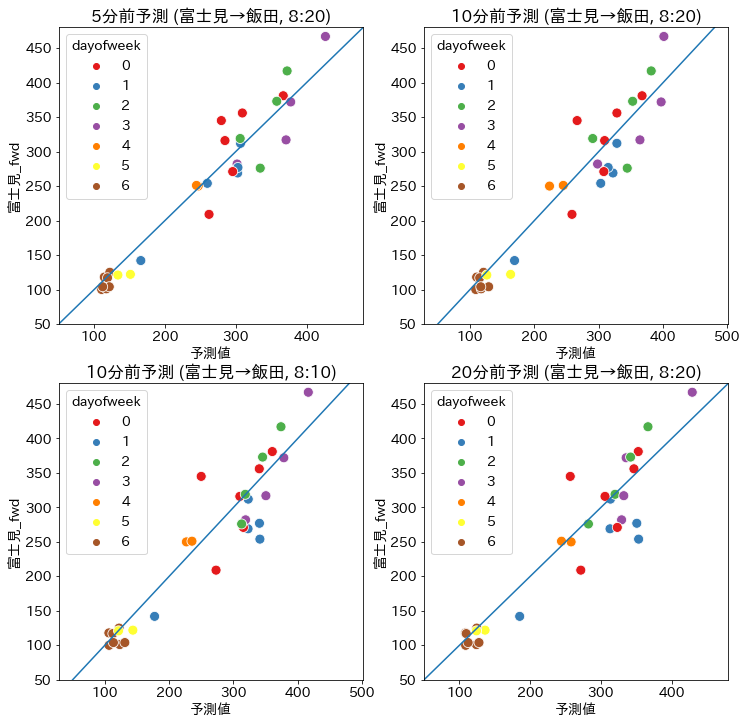

In [27]:
# 描画
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(2,2, figsize=(12,12))
sns.scatterplot(data=result, x='予測値', y='富士見_fwd',s=100, ax=ax[0,0], hue='dayofweek', palette="Set1")
ax[0,0].set_title("5分前予測 (富士見→飯田, 8:20)")

sns.scatterplot(data=result2, x='予測値', y='富士見_fwd',s=100, ax=ax[0,1], hue='dayofweek', palette="Set1")
ax[0,1].set_title("10分前予測 (富士見→飯田, 8:20)")

sns.scatterplot(data=result3, x='予測値', y='富士見_fwd',s=100, ax=ax[1,0], hue='dayofweek', palette="Set1")
ax[1,0].set_title("10分前予測 (富士見→飯田, 8:10)")

sns.scatterplot(data=result4, x='予測値', y='富士見_fwd',s=100, ax=ax[1,1], hue='dayofweek', palette="Set1")
ax[1,1].set_title("20分前予測 (富士見→飯田, 8:20)")

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_ylim([50, 480])
        ax[j,j].set_xlim([50, 480])
        ax[i,j].plot([50,480], [50,480])

# 決定係数の計算
from sklearn.metrics import r2_score
print("R2 = " + str(r2_score(result[target_col], result['予測値'])))
print("R2 = " + str(r2_score(result2[target_col], result2['予測値'])))
print("R2 = " + str(r2_score(result3[target_col], result3['予測値'])))
print("R2 = " + str(r2_score(result4[target_col], result4['予測値'])))

# 交差検証

cross_val_scoreでは、パラメータcvで分割個数(fold)を指定する。既定値は5

- 分割はランダムに行う。
- 分割されたそれぞれ１つをテストデータと、残りをトレーニングデータとしてトレーニング、テストを行いscoreを計算する。



In [28]:
from sklearn.model_selection import cross_val_score

def NN_cross_val_score(df, target_col, input_cols):
    # 学習 (df_train, df_testは予め作っておく)
    mlp = MLPRegressor(activation="identity", hidden_layer_sizes=(30,), max_iter=20000)
    scores = cross_val_score(mlp, df[input_cols], df[target_col]) # cvで何回やるかを与える（分割数？）
    return scores

# 5分前予測
target_col = '富士見_fwd'
input_cols = ['富士見prev_mvs_fwd1', '飯田prev_mvs_fwd1', 'アルプスprev_mvs_fwd1']
scores = NN_cross_val_score(df4analysis, target_col, input_cols)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-Validation scores: [0.74039404 0.87722804 0.94731109 0.70561593 0.76256616]
Accuracy: 0.81 (+/- 0.18)


## 手動で何回か繰り返してみる

cross_val_scoreの値がなにを意味するかマニュアルではよくわからないので、

トレーニングデータとテストデータを毎回train_test_splitで分割して、結果からr2_scoreで決定係数を計算し、その平均をとってみる。


In [37]:
# 決定係数の計算
from sklearn.metrics import r2_score
# 5分前予測
target_col = '富士見_fwd'
input_cols = ['富士見prev_mvs_fwd1', '飯田prev_mvs_fwd1', 'アルプスprev_mvs_fwd1']

r2_result= []
for i in range(5):
    # トレーニングデータとテストデータへの分割
    df_train, df_test = train_test_split(df4analysis, test_size=0.3)
    # NN_analysisは上で定義した関数で、NNで計算して結果と実測値とを返すもの
    result = NN_analysis(target_col, input_cols)
    r2_result.append(r2_score(result[target_col], result['予測値']))

print(r2_result)
import numpy as np
print('Average : {}'.format(np.mean(r2_result)))


[0.8595079556752846, 0.832699944140844, 0.8737066188581972, 0.8402425063114464, 0.9175878824308564]
Average : 0.8647489814833257


トレーニングデータとテストデータの割合を7:3にするとr2が0.83程度、8:2にすると0.81くらいになるようだ。

もちろん毎回変わる。

結果を交差検証の結果と比べると、scoreはr2とほぼ同じものを評価しているようだ。

### SVR


In [50]:
# 5分前予測
target_col = '富士見_fwd'
input_cols = ['富士見prev_mvs_fwd1', '飯田prev_mvs_fwd1', 'アルプスprev_mvs_fwd1']
result = SVR_analysis(target_col, input_cols, kernel='linear')
# result[[target_col, "予測値"]]

#10分前予測
input_cols = ['富士見prev_mvs_fwd2', '飯田prev_mvs_fwd2', 'アルプスprev_mvs_fwd2']
result2 = SVR_analysis(target_col, input_cols, kernel='linear')
# result2[[target_col, "予測値"]]

#15分前予測
input_cols = ['富士見prev_mvs_fwd3', '飯田prev_mvs_fwd3', 'アルプスprev_mvs_fwd3']
result3 = SVR_analysis(target_col, input_cols, kernel='linear')

#20分前予測
input_cols = ['富士見prev_mvs_fwd4', '飯田prev_mvs_fwd4', 'アルプスprev_mvs_fwd4']
result4 = SVR_analysis(target_col, input_cols, kernel='linear')

R2 = 0.859020232428475
R2 = 0.8886852210294637
R2 = 0.8916137447589417
R2 = 0.8655952190441549


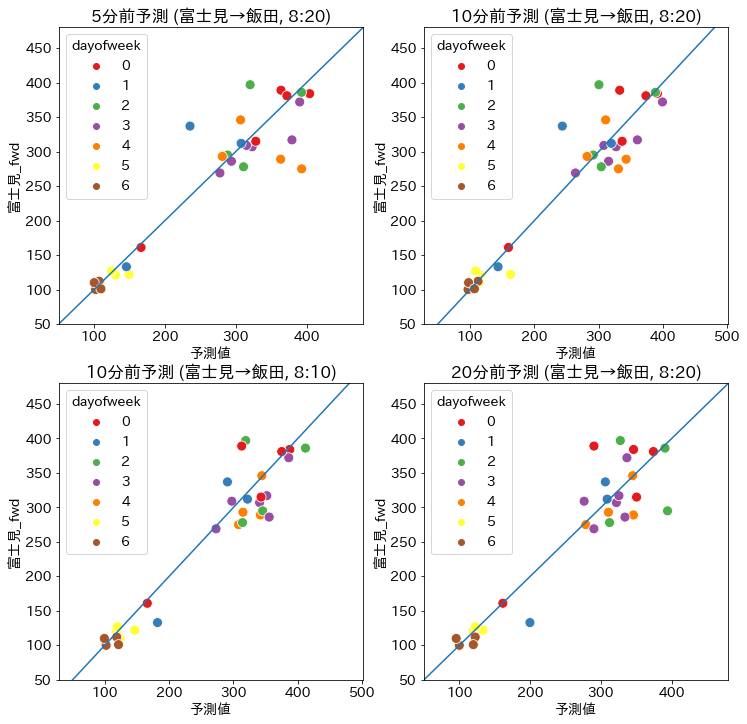

In [51]:
# 描画
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(2,2, figsize=(12,12))
sns.scatterplot(data=result, x='予測値', y='富士見_fwd',s=100, ax=ax[0,0], hue='dayofweek', palette="Set1")
ax[0,0].set_title("5分前予測 (富士見→飯田, 8:20)")

sns.scatterplot(data=result2, x='予測値', y='富士見_fwd',s=100, ax=ax[0,1], hue='dayofweek', palette="Set1")
ax[0,1].set_title("10分前予測 (富士見→飯田, 8:20)")

sns.scatterplot(data=result3, x='予測値', y='富士見_fwd',s=100, ax=ax[1,0], hue='dayofweek', palette="Set1")
ax[1,0].set_title("10分前予測 (富士見→飯田, 8:10)")

sns.scatterplot(data=result4, x='予測値', y='富士見_fwd',s=100, ax=ax[1,1], hue='dayofweek', palette="Set1")
ax[1,1].set_title("20分前予測 (富士見→飯田, 8:20)")

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_ylim([50, 480])
        ax[j,j].set_xlim([50, 480])
        ax[i,j].plot([50,480], [50,480])

# 決定係数の計算
from sklearn.metrics import r2_score
print("R2 = " + str(r2_score(result[target_col], result['予測値'])))
print("R2 = " + str(r2_score(result2[target_col], result2['予測値'])))
print("R2 = " + str(r2_score(result3[target_col], result3['予測値'])))
print("R2 = " + str(r2_score(result4[target_col], result4['予測値'])))